In [56]:
import os
import yaml
import geopandas as gpd
import datetime
import numpy as np
import rasterio as rio
from rasterio.crs import CRS
from rasterio.mask import mask
from shapely.geometry import box
import matplotlib.pyplot as plt

### Parameters

In [2]:
EVENT_NAME = 'bioko_fire_2024'

### Read YAML

In [3]:
yaml_file = f'../../dist-s1-research/marshak/10_ad_hoc_data_generation/events/{EVENT_NAME}.yml'
with open(yaml_file) as f:
    event_dict = yaml.safe_load(f)["event"]
event_dict

{'event_name': 'bioko_fire_2024',
 'bounds': [8.73555504, 3.56664088, 8.7688816, 3.59751284],
 'event_date': '2024-02-07',
 'pre_event_window_days': 100,
 'post_event_window_days': 60,
 'rtc_track_numbers': [30, 51],
 'mgrs_tiles': ['32NMJ'],
 'dist_hls_confirmed_change_min_days': 30,
 'source_id': 'UNOSAT via humanitarian data exchange - Sentinel-2',
 'links': ['data: https://data.humdata.org/dataset/areas-burned-from-february-3rd-to-18th-2024-around-the-pico-basil-volcano-on-bioko-island-',
  'https://go.ifrc.org/emergencies/6858/details']}

In [4]:
aoi = box(*event_dict['bounds'])
df_aoi = gpd.GeoDataFrame(geometry=[aoi], crs=CRS.from_epsg(4326))

In [5]:
df_mgrs = gpd.read_parquet('../../dist-s1-research/marshak/10_ad_hoc_data_generation/mgrs.parquet')
df_mgrs_overlapping = df_mgrs[df_mgrs.tile_id.isin(event_dict['mgrs_tiles'])].reset_index(drop=True)

In [6]:
df_mgrs_overlapping = df_mgrs[df_mgrs.tile_id.isin(event_dict['mgrs_tiles'])].reset_index(drop=True)
df_mgrs_overlapping.head()

,tile_id,epsg,utm_wkt,geometry
0,32NMJ,32632,"MULTIPOLYGON(((399960 400020,399960 290220,509...","MULTIPOLYGON (((8.09922 3.61861, 8.10006 2.625..."


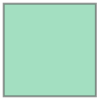

In [7]:
search_geo = box(*df_mgrs_overlapping.total_bounds)
search_geo

### Load RADD regions

In [8]:
# Load RADD regions (for later use)
radd_regions_gdf = gpd.read_file('./data/Deforestation_alerts_(RADD).shp')
radd_regions_gdf = radd_regions_gdf.rename(columns={'tile_id': 'radd_tile_id'})
radd_regions_gdf

,radd_tile_id,download,ObjectId,Shape__Are,Shape__Len,geometry
0,00N_000E,https://data-api.globalforestwatch.org/dataset...,1,1.245543e+12,4.464170e+06,"POLYGON ((0 0, 10 0, 10 -10, 0 -10, 0 0))"
1,00N_010E,https://data-api.globalforestwatch.org/dataset...,2,1.245543e+12,4.464170e+06,"POLYGON ((10 0, 20 0, 20 -10, 10 -10, 10 0))"
2,00N_020E,https://data-api.globalforestwatch.org/dataset...,3,1.245543e+12,4.464170e+06,"POLYGON ((20 0, 30 0, 30 -10, 20 -10, 20 0))"
3,00N_030E,https://data-api.globalforestwatch.org/dataset...,4,1.245543e+12,4.464170e+06,"POLYGON ((30 0, 40 0, 40 -10, 30 -10, 30 0))"
4,00N_040E,https://data-api.globalforestwatch.org/dataset...,5,1.245543e+12,4.464170e+06,"POLYGON ((40 0, 50 0, 50 -10, 40 -10, 40 0))"
...,...,...,...,...,...,...
66,20S_050W,https://data-api.globalforestwatch.org/dataset...,67,1.369807e+12,4.687428e+06,"POLYGON ((-50 -20, -40 -20, -40 -30, -50 -30, ..."
67,20S_060W,https://data-api.globalforestwatch.org/dataset...,68,1.369807e+12,4.687428e+06,"POLYGON ((-60 -20, -50 -20, -50 -30, -60 -30, ..."
68,20S_070W,https://data-api.globalforestwatch.org/dataset...,69,1.369807e+12,4.687428e+06,"POLYGON ((-70 -20, -60 -20, -60 -30, -70 -30, ..."
69,30N_110E,https://data-api.globalforestwatch.org/dataset...,70,1.369807e+12,4.687428e+06,"POLYGON ((110 30, 120 30, 120 20, 110 20, 110 ..."


In [9]:
# Find the RADD tiles corresponding to the MGRS tiles of interest
mgrs_radd_df = gpd.sjoin(df_mgrs_overlapping, radd_regions_gdf, how="inner", predicate="intersects")
mgrs_radd_df

,tile_id,epsg,utm_wkt,geometry,index_right,radd_tile_id,download,ObjectId,Shape__Are,Shape__Len
0,32NMJ,32632,"MULTIPOLYGON(((399960 400020,399960 290220,509...","MULTIPOLYGON (((8.09922 3.61861, 8.10006 2.625...",19,10N_000E,https://data-api.globalforestwatch.org/dataset...,20,1.245543e+12,4.464170e+06


<Axes: >

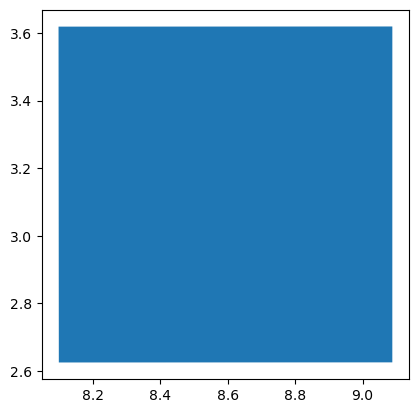

In [10]:
# plot an overview of the filtered RADD tiles
fig, ax = plt.subplots()
mgrs_radd_df.plot(ax = ax)

### Download and merge RADD tiles

In [59]:
## RADD related functions
# function to download RADD image 
def download_file(url, save_dir, filename):
    import os
    import requests
     # Ensure the directory exists
    os.makedirs(save_dir, exist_ok=True)
    
    # Complete file path
    file_path = os.path.join(save_dir, filename)

    if os.path.exists(file_path):
        print(f"File already exists at {file_path}. Skipping download.")
        return
    
    # Download the file
    response = requests.get(url)
    response.raise_for_status()  # Check for request errors
    
    # Save the file
    with open(file_path, 'wb') as file:
        file.write(response.content)
    
    print(f"File downloaded and saved to {file_path}")


def load_tiff(tiff_path):
    with rio.open(tiff_path) as src:
        # Read the entire file into an array
        data_arr = src.read()
        geo_transform = src.transform
        # Calculate the spatial extent
        spatial_extents = [
            geo_transform[2],  # min X
            geo_transform[2] + geo_transform[0] * data_arr.shape[2],  # max X
            geo_transform[5] + geo_transform[4] * data_arr.shape[1],  # min Y
            geo_transform[5]  # max Y
        ]

    return data_arr, spatial_extents, geo_transform  


def get_mgrs_tile_from_radd(polygon, path_to_radd):
    '''
    Use the MGRS extents to read that portion of the RADD alert.
    Inputs:
        MGRS polygon
        path to RADD image
    Returns:
        RADD cropped array
        RADD spatial extent
    '''

    gdf = gpd.GeoDataFrame({'geometry': [polygon]}, crs=CRS.from_epsg(4326))

    with rio.open(path_to_radd) as src:
        # Reproject the GeoDataFrame to match the raster's CRS, if necessary
        gdf = gdf.to_crs(src.crs)
        
        # Mask the raster with the polygon
        out_image, out_transform = mask(src, gdf.geometry, crop=True)
        
        # Calculate the spatial extent
        spatial_extent = [
            out_transform[2],  # min X
            out_transform[2] + out_transform[0] * out_image.shape[2],  # max X
            out_transform[5] + out_transform[4] * out_image.shape[1],  # min Y
            out_transform[5]  # max Y
        ]
    
    return out_image[0], spatial_extent, out_transform


def export_array(arr, geo_transform, outpath):
    from rasterio.transform import Affine
    crs = CRS.from_epsg(4326)  # RADD tiles are in EPSG:4326
    # Export the array as a GeoTIFF
    with rio.open(
        outpath, 
        'w', 
        driver='GTiff', 
        height=arr.shape[0], 
        width=arr.shape[1], 
        count=1,  # Number of bands
        dtype=arr.dtype, 
        crs=crs, 
        transform=geo_transform
    ) as dst:
        dst.write(arr, 1)

    print(f"GeoTIFF saved at {outpath}")


def merge_tiffs(path_list, outpath):
    from rasterio.merge import merge
    # Open all TIFFs into a list
    datasets = [rio.open(path) for path in path_list] 
    # Merge all 
    merged_array, merged_transform = merge(datasets)
    # Update the metadata for the merged file based on the first dataset
    merged_meta = datasets[0].meta.copy()
    merged_meta.update({
        "driver": "GTiff",
        "height": merged_array.shape[1],
        "width": merged_array.shape[2],
        "transform": merged_transform
    })
    
    # Write the merged array to a new GeoTIFF file
    with rio.open(outpath, "w", **merged_meta) as dst:
        dst.write(merged_array)
    
    # Close all the datasets
    for dataset in datasets:
        dataset.close()

    print(f"Merged GeoTIFF saved at {outpath}")


# Give a date and return a RADD encoded value 
def encode_alert_date(date: datetime, confidence: str) -> int:
    """
    Encodes a given date and confidence level into an integer representation.

    Parameters:
    - date (datetime): The date of the disturbance.
    - confidence (str): The confidence level, either 'low' or 'high'.

    Returns:
    - int: Encoded alert date number.
    """
    # Reference date (start date)
    start_date = datetime.datetime(2014, 12, 31)
    
    # Calculate the number of days since the reference date
    days_since_start = (date - start_date).days
    
    # Determine the leading integer based on confidence level
    if confidence.lower() == 'low':
        leading_digit = 2
    elif confidence.lower() == 'high':
        leading_digit = 3
    else:
        raise ValueError("Confidence level must be 'low' or 'high'.")
    
    # Combine the leading digit with the days since the reference date
    encoded_value = int(f"{leading_digit}{days_since_start:04d}")  # Zero-pads the days to ensure correct formatting
    
    return encoded_value


# Remove tif files from directory after use
def remove_tif_files(directory, pattern="*.tif"):
    import os
    import fnmatch

    # Check if the directory exists
    if os.path.exists(directory):
        # Iterate over the files in the specified directory
        for filename in os.listdir(directory):
            if fnmatch.fnmatch(filename, pattern):
                file_path = os.path.join(directory, filename)
                try:
                    os.remove(file_path)  # Remove the file matching the pattern
                    print(f'Removed file: {file_path}')
                except Exception as e:
                    print(f'Failed to delete {file_path}. Reason: {e}')
        print(f"All files matching the pattern '{pattern}' in the directory '{directory}' have been removed.")
    else:
        print(f"The directory '{directory}' does not exist.")

In [12]:
# Download RADD data
radd_alert_paths = []
for index, row in mgrs_radd_df.iterrows():
    link = row['download']
    print(f"Downloading RADD tile {row['radd_tile_id']} that overlaps MGRS tile {row['tile_id']}")
    # check out dir
    save_dir = './data/radd'
    # filename 
    radd_alert = 'radd_tile_'+ row['radd_tile_id'] + '.tif'
    radd_alert_paths.append(os.path.join(save_dir, radd_alert))
    # run
    download_file(link, save_dir, radd_alert)

File already exists at ./data/radd/radd_tile_10N_000E.tif. Skipping download.


In [13]:
mgrs_radd_df

,tile_id,epsg,utm_wkt,geometry,index_right,radd_tile_id,download,ObjectId,Shape__Are,Shape__Len
0,32NMJ,32632,"MULTIPOLYGON(((399960 400020,399960 290220,509...","MULTIPOLYGON (((8.09922 3.61861, 8.10006 2.625...",19,10N_000E,https://data-api.globalforestwatch.org/dataset...,20,1.245543e+12,4.464170e+06


In [14]:
# We use the MGRS polygon boundaries to extract the corresponding portion of the RADD alert.
# Extract polygon from multipolygon
print(mgrs_radd_df.iloc[0]['geometry'].geoms[0])

POLYGON ((8.09921884814274 3.61860907612695, 8.10006456603865 2.62536733030413, 9.08780218634007 2.62568983172676, 9.08788471225469 3.61905385708534, 8.09921884814274 3.61860907612695))


In [15]:
# Download tiles and merge if necessary
radd_out_dir = './data/radd' # Radd out direcotry 
radd_tile_num = len(mgrs_radd_df)
if radd_tile_num >= 2:
    print('Multiple RADD tiles available read and merge')
    radd_tile_paths = []
    for tile in range(radd_tile_num):
       # Extract RADD tile
       radd_arr, _, radd_gt = get_mgrs_tile_from_radd(mgrs_radd_df.iloc[tile]['geometry'].geoms[0], radd_alert_paths[tile])
       # Save tile as tiff
       out_tile = f"{radd_out_dir}/radd_tile_subset{tile}.tif"
       export_array(radd_arr, radd_gt, out_tile)
       radd_tile_paths.append(out_tile)
    
    # Merge tiles 
    merged_out = f"{radd_out_dir}/radd_merged.tif"
    merge_tiffs(radd_tile_paths, merged_out)  
    # Delete tiles (since they are merged no need to keep them)
    remove_tif_files(radd_out_dir, pattern="*_subset*.tif") 
    # load merged file to filter events
    radd_arr, radd_se, radd_gt = load_tiff(merged_out)

elif radd_tile_num == 1: 
    print('Only one tile to read, continue to filter and export')
    # load subset of RADD
    radd_arr, radd_se, radd_gt = get_mgrs_tile_from_radd(mgrs_radd_df.iloc[0]['geometry'].geoms[0], radd_alert_paths[0])


Only one tile to read, continue to filter and export


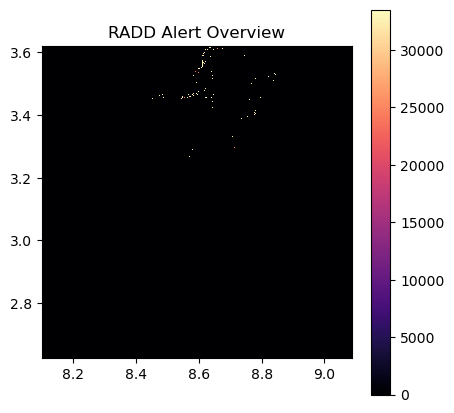

In [16]:
# Plot overview
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(1, 1, 1)
cax = ax.imshow(radd_arr, cmap='magma', extent=radd_se, interpolation='nearest')
ax.set_title("RADD Alert Overview")
cbar = fig.colorbar(cax, orientation='vertical')
plt.show()

### Filter RADD alerts

In [33]:
EVENT_DT = datetime.datetime.strptime(event_dict['event_date'], "%Y-%m-%d")
print(EVENT_DT)

2024-02-07 00:00:00 2023-10-30 00:00:00 2024-04-07 00:00:00


In [60]:
# Test the encoded alert translator
date1 = datetime.datetime(2015, 1, 1)  # January 1st, 2015
date2 = datetime.datetime(2015, 2, 24) # February 24, 2015
date3 = datetime.datetime(2020, 1, 21) # January 21, 2020

print(encode_alert_date(date1, 'low'))   # Output: 20001
print(encode_alert_date(date2, 'high'))  # Output: 30055
print(encode_alert_date(date3, 'low'))   # Output: 21847


20001
30055
21847


In [63]:
# Use the encoded alert translator to filter pixels of interest
# get alerts from 2022 to 60 days after the event
pre_event_date = datetime.datetime(2022, 1, 1)  # January 1st, 2015
post_evet_date = EVENT_DT + datetime.timedelta(days=60) # 60 days after event

pre_event_date_code_low = encode_alert_date(pre_event_date, 'low')
post_event_date_code_low = encode_alert_date(post_evet_date, 'low')
pre_event_date_code_high = encode_alert_date(pre_event_date, 'high')
post_event_date_code_high = encode_alert_date(post_evet_date, 'high')

print(pre_event_date_code_low, 
      post_event_date_code_low,
      pre_event_date_code_high,
      post_event_date_code_high 
      )

22558 23385 32558 33385


In [64]:
# Get masks
low_confidence_mask = (radd_arr > pre_event_date_code_low) & (radd_arr < post_event_date_code_low)
high_confidence_mask = (radd_arr > pre_event_date_code_high) & (radd_arr < post_event_date_code_high)

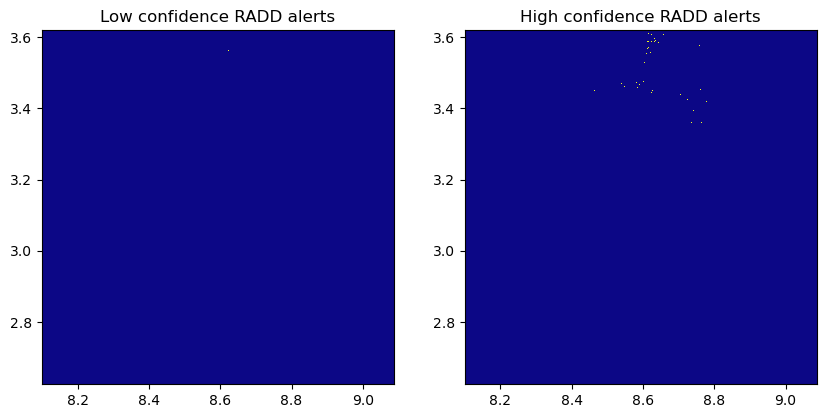

In [67]:
# Plot overview
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 2, 1)
cax = ax.imshow(low_confidence_mask, cmap='plasma', extent=radd_se, interpolation='nearest')
ax.set_title("Low confidence RADD alerts")
ax = fig.add_subplot(1, 2, 2)
cax = ax.imshow(high_confidence_mask, cmap='plasma', extent=radd_se, interpolation='nearest')
ax.set_title("High confidence RADD alerts")
plt.show()

## Export final masks

In [ ]:
lcm_out = f"{radd_out_dir}/radd_low_confidence_mask.tif"
export_array(low_confidence_mask, radd_gt, lcm_out)
hcm_out = f"{radd_out_dir}/radd_high_confidence_mask.tif"
export_array(high_confidence_mask, radd_gt, hcm_out) 